# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [68]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)
import statsmodels.api as sm

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [69]:
# Read in the dataset and get overview
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [70]:
# Number of rows
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [71]:
# number of unique user_ids
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [72]:
# number of converted divided by unique users
df.converted.sum() / df.user_id.nunique()

0.12126269856564711

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page` **(checked `control` and not `old_page` also)**

In [73]:
# identify the number of mis-matches
print(df.landing_page.unique()) # check unique column entries
df.query('group == "treatment" and landing_page != "new_page"').count() + \
df.query('group == "control" and landing_page != "old_page"').count()

['old_page' 'new_page']


user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

**f.** Do any of the rows have missing values?

In [74]:
# identify missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [75]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
treat_new = df.query('group == "treatment" and landing_page == "new_page"')
contrl_old = df.query('group == "control" and landing_page == "old_page"')
df2 = treat_new.append(contrl_old, verify_integrity=True)

In [76]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statements below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0], \
df2.query('group == "control" and landing_page != "old_page"').shape[0]

(0, 0)

In [77]:
# remaining number of rows
df2.shape[0]

290585

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [78]:
# unique user_ids in df2
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [79]:
# find duplicated user_id
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [80]:
# find both entries of the identified duplicated user_id
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [81]:
# Remove one of the rows with a duplicate user_id..
df2.drop(labels=2893, inplace=True)

# Check again if the row with a duplicate user_id is deleted or not
print(df2.shape[0])
df2.query('user_id == 773192')

290584


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [82]:
# take mean of 1's and 0's in 'converted' column to get proportion/probability
df2.converted.mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [83]:
# control group conversion rate
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [84]:
# treatment group conversion rate
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

In [85]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [86]:
# Number of new_page (treatment) and old_page (control) users
df2.landing_page.value_counts() 

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [87]:
# calc overall probability of receiving the new_page
p_newpage = df2.landing_page.value_counts()[0] / df2.shape[0]
p_newpage

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

In [88]:
# check duration of experiment
df2.timestamp.min(), df2.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

>**Based on the above conversion rates (probabilities), it does not appear that the treatment/new_page group lead to more conversions. However, the experiment could be run again, or the initial experiment could have been run longer... In any case, let's use bootstrapping/simulation to get a better understanding if the `obs-diff` may be statistically significant or not (i.e. to understand if the `obs_diff` is likely due to chance or not).**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Put your answer here.**

>**$H_0:  p_{new} \leq p_{old}$**

>**$H_1:  p_{new} > p_{old}$**

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [89]:
# p_new = p_old = p_pop
p_old = p_new = df2.converted.mean()
print(p_new)

0.11959708724499628


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [90]:
# print out p_old
print(p_old)

0.11959708724499628


**c.** What is $n_{new}$, the number of individuals in the treatment group? 

In [91]:
# num of users in treatment group
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [92]:
# num of users in control group
n_old = df2.query('group == "control"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.

In [93]:
# Simulate a sample for the treatment Group
new_prob_array = np.array([1-p_new, p_new]) # random.choice probabilities array input
new_page_converted = np.random.choice(2, size=n_new, replace=True, p=new_prob_array)

In [94]:
# p'_new
new_page_converted.mean()

0.11948936755901177

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null 

In [95]:
# Simulate sample for the control Group
old_prob_array = np.array([1-p_old, p_old]) # random.choice probabilities array input
old_page_converted = np.random.choice(2, size=n_old, replace=True, p=old_prob_array)

In [96]:
#p'_old
old_page_converted.mean()

0.11929182097278247

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [97]:
# p'_new - p'_old
sim_samp_diff = new_page_converted.mean() - old_page_converted.mean()
sim_samp_diff 

0.0001975465862292941


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [98]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(2, size=n_new, replace=True, p=new_prob_array)
    old_page_converted = np.random.choice(2, size=n_old, replace=True, p=old_prob_array)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

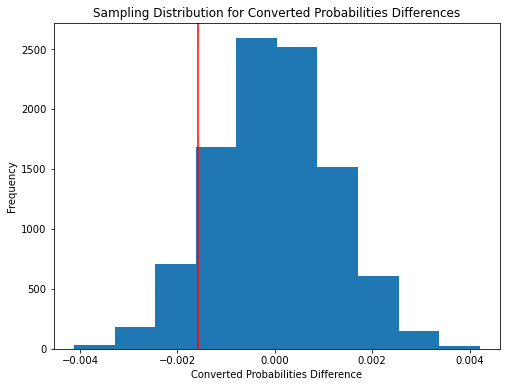

In [99]:
# plot p_diff sampling distribution, should be approximately a normal distribution (...and it is!)
plt.figure(figsize=(8,6))
plt.hist(p_diffs)
plt.axvline(obs_diff, c='r')
plt.xlabel("Converted Probabilities Difference")
plt.ylabel("Frequency")
plt.title("Sampling Distribution for Converted Probabilities Differences");

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [100]:
# proportion of p_diffs greater than obs_diff
(p_diffs > obs_diff).mean()

0.9027

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**Part j. computation result is called a "p-value". A p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.**
>
>**The p-value of ~0.9049 is much greater than the Type I error rate (i.e. $\alpha$) threshold of 0.05 (5%), which would indicate that the statistic would likely come from the null distribution, and therefore we "fail to reject the null hypothesis". In other words, the observed difference statistic does not appear to be statistically significant.**
>
>**Part j. computation was comprised of:**
>
> * The `p_diff` list of 10,000 mean difference values resulting from the bootstrap sample simulation (i.e. more specifically from the `new_page_converted.mean()` - `old_page_converted.mean()` calc).
>
> * The `obs_diff` which is the difference between the conversion rates of the two groups in the A/B Test (landing page) experiment found earlier.
>
> * The bracketed expression results in a boolean array with 1's where a `p_diff` distribution value is greater than the observed difference `obs_diff` value (i.e. located to the right of the red vertical line in the plot), and 0's when it is not.
>
> * `.mean()` function results in the proportion of the `p_diff` distribution values which are greater than the `obs_diff` value - i.e. the probabilitiy of observing our statistic if the null hypothesis is true.**

>****Note:** The typical step of creating a normal distribution centered on the null (zero) was omitted based on the template provided/guidance provided and for the sake of practicality since for the current intents and purposes, the bootstrap sample distribution was essentially already centered on zero.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [101]:
# number of conversions with the old_page
convert_old = df2[df2['group'] == 'control']['converted'].sum()

# number of conversions with the new_page
convert_new = df2[df2['group'] == 'treatment']['converted'].sum()

# number of individuals who were shown the old_page
# n_old ...already assigned above/earlier (same variable name used)

# number of individuals who received new_page
# n_new ...already assigned above/earlier (same variable name used)

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [131]:
# inputs for z-test
count_array = [convert_new, convert_old]
nobs_array = [n_new, n_old]
alternative = ['larger']

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 

In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org


In [132]:
import statsmodels.api as sm
# obtain sm.stats.proportions_ztest()results
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>**Yes, the z-score and p-value both support the sample distribution p-value result. In the case of the current p-value, it is very close to the p-value from the bootstrap sampling distibution approach above; and in terms of the z-score, 1.31 < 1.960, so with this test we would also "fail to reject the null". Overall the findings support that the `new_page` does not improve/increase conversion.**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

In [104]:
# quick overview of dataframe before moving forward
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


>**Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [105]:
# prep for regression - add new columns
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [106]:
# instantiate regression model and fit model to predict/provide results
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [107]:
# provide summary of results
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-12-13 14:56 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [108]:
# coefficients
results.params

intercept   -1.988777
ab_page     -0.014989
dtype: float64

In [109]:
# exponentiate coefficient of interest (ab_page)
np.exp(results.params[1])

0.9851226640350396

In [110]:
# reciprocal of exponentiated coefficient (i.e. opposite perspective on variable impact)
1/np.exp(results.params[1])

1.0151020136964704

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

>**Regression p-value = 0.1899**
>
>**The p-values differ because earlier in the z-test (and the bootstrap sampling distribution) we had a one-sided hypothesis (i.e. $H_0 \geq H_1$ (null) and $H_1 > H_0$ (alt)), and in regression we have a two-sided hypothesis (i.e. $H_0 = 0$ (null) and $H_1 \neq 1$ (alt)); and, therefore the latter p-value is essentially the sum of areas under both tails of the probability distribution.**
>
>**Therefore, taking half of the regression p-value we end up with approximately the same p-value from the one-sided p-values from earlier:**
>* ~0.19/2 ~= 0.095
>
>**As with earlier, considering the significance threshold for Type 1 errors, $\alpha$ = 0.05, vs the regression p-value (~0.095), we again "fail to reject the null hypothesis", i.e. the `new_page` does not appear to increase conversion.**



**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Advantages/reasons to include multiple factors/variables:**
>* Predict response variables based on multiple inputs/factors (which is more common in the real world)
>* Convenient to model a response based on multiple inputs at once.
>* Provides "ability to determine the relative influence of one or more predictor variables to the criterion value." (Sciencing article https://sciencing.com/advantages-disadvantages-multiple-regression-model-12070171.html)
>* Provides the "the ability to identify outliers, or anomalies."(Sciencing article https://sciencing.com/advantages-disadvantages-multiple-regression-model-12070171.html)
>* Higher order terms and interactions can be added to improve model fit/prediction (e.g. interaction terms may improve R-squared).
>
>
>**Disadvantages: Problems can occur (Udacity DAND, Lesson 16, Concept 14)*:**
>* "A linear relationship may not exist
>* Correlated errors
>* Non-constant variance
>* Outliers
>* Multicollinearity" (e.g. flipped x-variable coefficients).
>* Also, for Higher Order & Interaction terms: You can no longer interpret lower order variables as you could originally, and higher order terms can be difficult/impossible to confidently interpret. 
>
>*Additional detail can be found in DAND Udacity Lesson 16. Multiple Linear Regression, Concept 15. "[Optional] Text: Linear Model Assumptions".

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [111]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [112]:
# checking country data
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [113]:
# join dataframes (using new indexes based on user_id)
df_merged = df2.set_index('user_id').join(countries_df.set_index('user_id'), how='inner')
print(df_merged.info())
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 661590 to 697314
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     290584 non-null  object
 1   group         290584 non-null  object
 2   landing_page  290584 non-null  object
 3   converted     290584 non-null  int64 
 4   intercept     290584 non-null  int64 
 5   ab_page       290584 non-null  uint8 
 6   country       290584 non-null  object
dtypes: int64(2), object(4), uint8(1)
memory usage: 15.8+ MB
None


,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [114]:
# checking unique entries in country column
df_merged.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [115]:
# Create the necessary dummy variables (dropping first dummy column)
df_merged = pd.get_dummies(df_merged, columns=['country'], drop_first=True)
df_merged

,timestamp,group,landing_page,converted,intercept,ab_page,country_UK,country_US
user_id,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,0
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,0
...,...,...,...,...,...,...,...,...
718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0,0,1
751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,0,1
945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,0,1


In [116]:
# adding intercept, instantiating and fitting logistic regression model, output summary results
df_merged['intercept'] = 1
log_mod1 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'country_UK', 'country_US']])
results1 = log_mod1.fit()
results1.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-12-13 14:56 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
country_UK     0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
country_US     0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

In [117]:
# exponentiate coefficients
np.exp(results1.params)

intercept     0.130350
country_UK    1.052027
country_US    1.041647
dtype: float64

**Question 2. restated: Does it appear that country had an impact on conversion?**
>Based on the p-values (and z-values, i.e. std deviations < 2), it does not appear that the `country` has a statistically significant impact.
>
>**Coefficient Interpretations:**
>* Conversion is ~1.052 times as likely for UK-users than CA-users (baseline), holding all else constant.
>* Conversion is ~1.042 times as likely for US-users than CA-users (baseline), holding all else constant.

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

In [118]:
# Instantiate and fit model, and summarize the results
log_mod2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'country_UK', 'country_US']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-12-13 14:56 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
country_UK     0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
country_US     0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

In [119]:
# exponentiate coeff.
np.exp(results2.params)

intercept     0.131332
ab_page       0.985168
country_UK    1.051944
country_US    1.041599
dtype: float64

In [120]:
# add interaction term column to dataframe 
df_merged['ab_page_UK'] = df_merged['ab_page'] * df_merged['country_UK']

In [121]:
# quick look at dataframe
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country_UK,country_US,ab_page_UK
user_id,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,0
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,0,1
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,0,0


In [122]:
# instantiate and fit model, summarize results
log_mod3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'ab_page_UK', 'country_UK', 'country_US']])
results3 = log_mod3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.4204
Date:               2021-12-13 14:56 BIC:              212834.3187
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           4                LL-Null:          -1.0639e+05
Df Residuals:       290579           LLR p-value:      0.15568    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0257    0.0268  -75.5180  0.0000  -2.0783  -1.9731
ab_page       -0.0236    0.0132   -1.7853  0.0742  -0.0495   0.0023
ab_page_UK     0.0344    0.0264    1.3057  0.1917  -0.0172   0.0861
country_UK     0.0335    0.0313    1.0697  0.2848  -0.0279   0.0948
country_US     0.0407    0.0269    1.5151  0.1298  -0.0120   0.0934
==================================================================

"""

In [123]:
# exponentiate coeff.
np.exp(results3.params)

intercept     0.131901
ab_page       0.976686
ab_page_UK    1.035024
country_UK    1.034052
country_US    1.041571
dtype: float64

In [124]:
# add 2nd interaction term column to dataframe 
df_merged['ab_page_US'] = df_merged['ab_page'] * df_merged['country_US']

In [125]:
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country_UK,country_US,ab_page_UK,ab_page_US
user_id,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,0,1
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,0,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,0,1,0
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,0,0,0


In [126]:
# instantiate and fit model, summarize results
log_mod4 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'ab_page_UK', 'country_UK', 'ab_page_US', 'country_US']])
results4 = log_mod4.fit()
results4.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-12-13 14:56 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
ab_page_UK     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
country_UK     0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
ab_page_US     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
country_US     0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
==================================================================

"""

In [127]:
# exponentiate coeff.
np.exp(results4.params)

intercept     0.134794
ab_page       0.934776
ab_page_UK    1.081428
country_UK    1.011854
ab_page_US    1.048001
country_US    1.017682
dtype: float64

>**After looking at the results from the various logistic regression models, it does not appear that the `ab_page` or `country` variables or their interactions have STATISTICAL SIGNIFICANT impact on conversion. This conclusion has been reached based on the high p-values (>0.05 Type 1 error threshold) and the low z-values (i.e. std deviations < 2); i.e. we fail to reject the null hypothesis. Further, from comparing the coefficients across the various logistic regression results, there were only slight differences.**
>
>**There does not appear* to be PRACTICAL SIGNIFICANCE to using the `new_page` regardless of country. To gain further insight on this, the probability of conversion was calculated using the coefficients from the last logistic regression results above (i.e. including both interaction terms), followed by the difference with the overall population conversion rate/probability....The resulting difference (shown 2 code cells below) is very small (~0.009) and further supports that there is no advantage to the `new_page`.** 
>
>***Caveats:**
**It should be noted that the study was carried out for less than a month, and it was in January after the big holiday spending spree (when consumer budgets can be exhausted) - different results could be seen if the experiment and data collection occurred over a longer or different time period.**

In [128]:
#solving directly for probability of conversion (includes effect of interaction terms)
p_new_countries = np.exp(results4.params.sum()) / (1 + np.exp(results4.params.sum()))
p_new_countries

0.12819924852433034

In [129]:
# difference between overall population p_pop conversion rate
p_new_countries - df_merged.converted.mean()

0.008602161279334067

<a id='finalcheck'></a>
## Final Check!

**Final check completed.**

<a id='submission'></a>
## Submission

**Submitted manually: uploaded via the Udacity project submission page.**


### Resources
* Stats Quest Videos (You-Tube): Logistic Regression Clearly Explained
https://www.youtube.com/watch?v=yIYKR4sgzI8
* Stats Quest Videos (You-Tube): Logistic Regression Details Part 1 https://www.youtube.com/watch?v=vN5cNN2-HWE
* Stats Quest Videos (You-Tube): Logistic Regression Details Part 2 https://www.youtube.com/watch?v=BfKanl1aSG0

In [130]:
#from subprocess import call - not required as project was completed on local machine.
#call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])